<a href="https://colab.research.google.com/github/nicolas1805961/GE_reinforcement_learning/blob/master/fork_of_ge_deep_q_learning_two_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#import glob
#import pydicom
#import numpy as np
#import matplotlib.pyplot as plt

#patient_path = glob.glob('/kaggle/input/ge-dqn/Patients/*')[0]
#files = []
#for slice_path in glob.glob(patient_path + '/*'):
#    files.append(pydicom.dcmread(slice_path))
#files = sorted(files, key=lambda s: s.SliceLocation)
#shape = files[0].pixel_array.shape
#shape = list(shape)
#shape.insert(0, len(files))
#img3d = np.zeros(shape)
#for i, s in enumerate(files):
#    img2d = s.pixel_array
#    img3d[i, :, :] = img2d
#print(img3d.shape)
#img = np.max(img3d, axis=0).T
#img = np.rot90(img, 2)
        
#plt.imshow(img3d[:, shape[1] // 2, :], cmap='bone')

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import math
import random
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [65]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [66]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from numpy.random import randint, choice
from torchvision.transforms.functional import affine
from PIL import Image
from sklearn.model_selection import train_test_split

data_train = pd.read_csv("/content/drive/My Drive/fashion-mnist_train.csv")
data_train = data_train.iloc[:, 1:].values
data_train = data_train.reshape((data_train.shape[0], 28, 28))
p = (50 - 28) // 2
data_train = np.pad(data_train, ((0, 0), (p, p), (p, p)), 'constant', constant_values=0)

In [67]:
data_test = pd.read_csv("/content/drive/My Drive/fashion-mnist_test.csv")
data_test = data_test.iloc[:, 1:].values
data_test = data_test.reshape((data_test.shape[0], 28, 28))
p = (50 - 28) // 2
data_test = np.pad(data_test, ((0, 0), (p, p), (p, p)), 'constant', constant_values=0)

In [68]:
data = np.concatenate((data_train, data_test))

In [69]:
del data_train
del data_test

In [70]:
data = data.astype(np.uint8)
print(data.shape)

(70000, 50, 50)


[ 0. -1.]
[-0. -1.]
[ 0. -5.]
[-0. -3.]


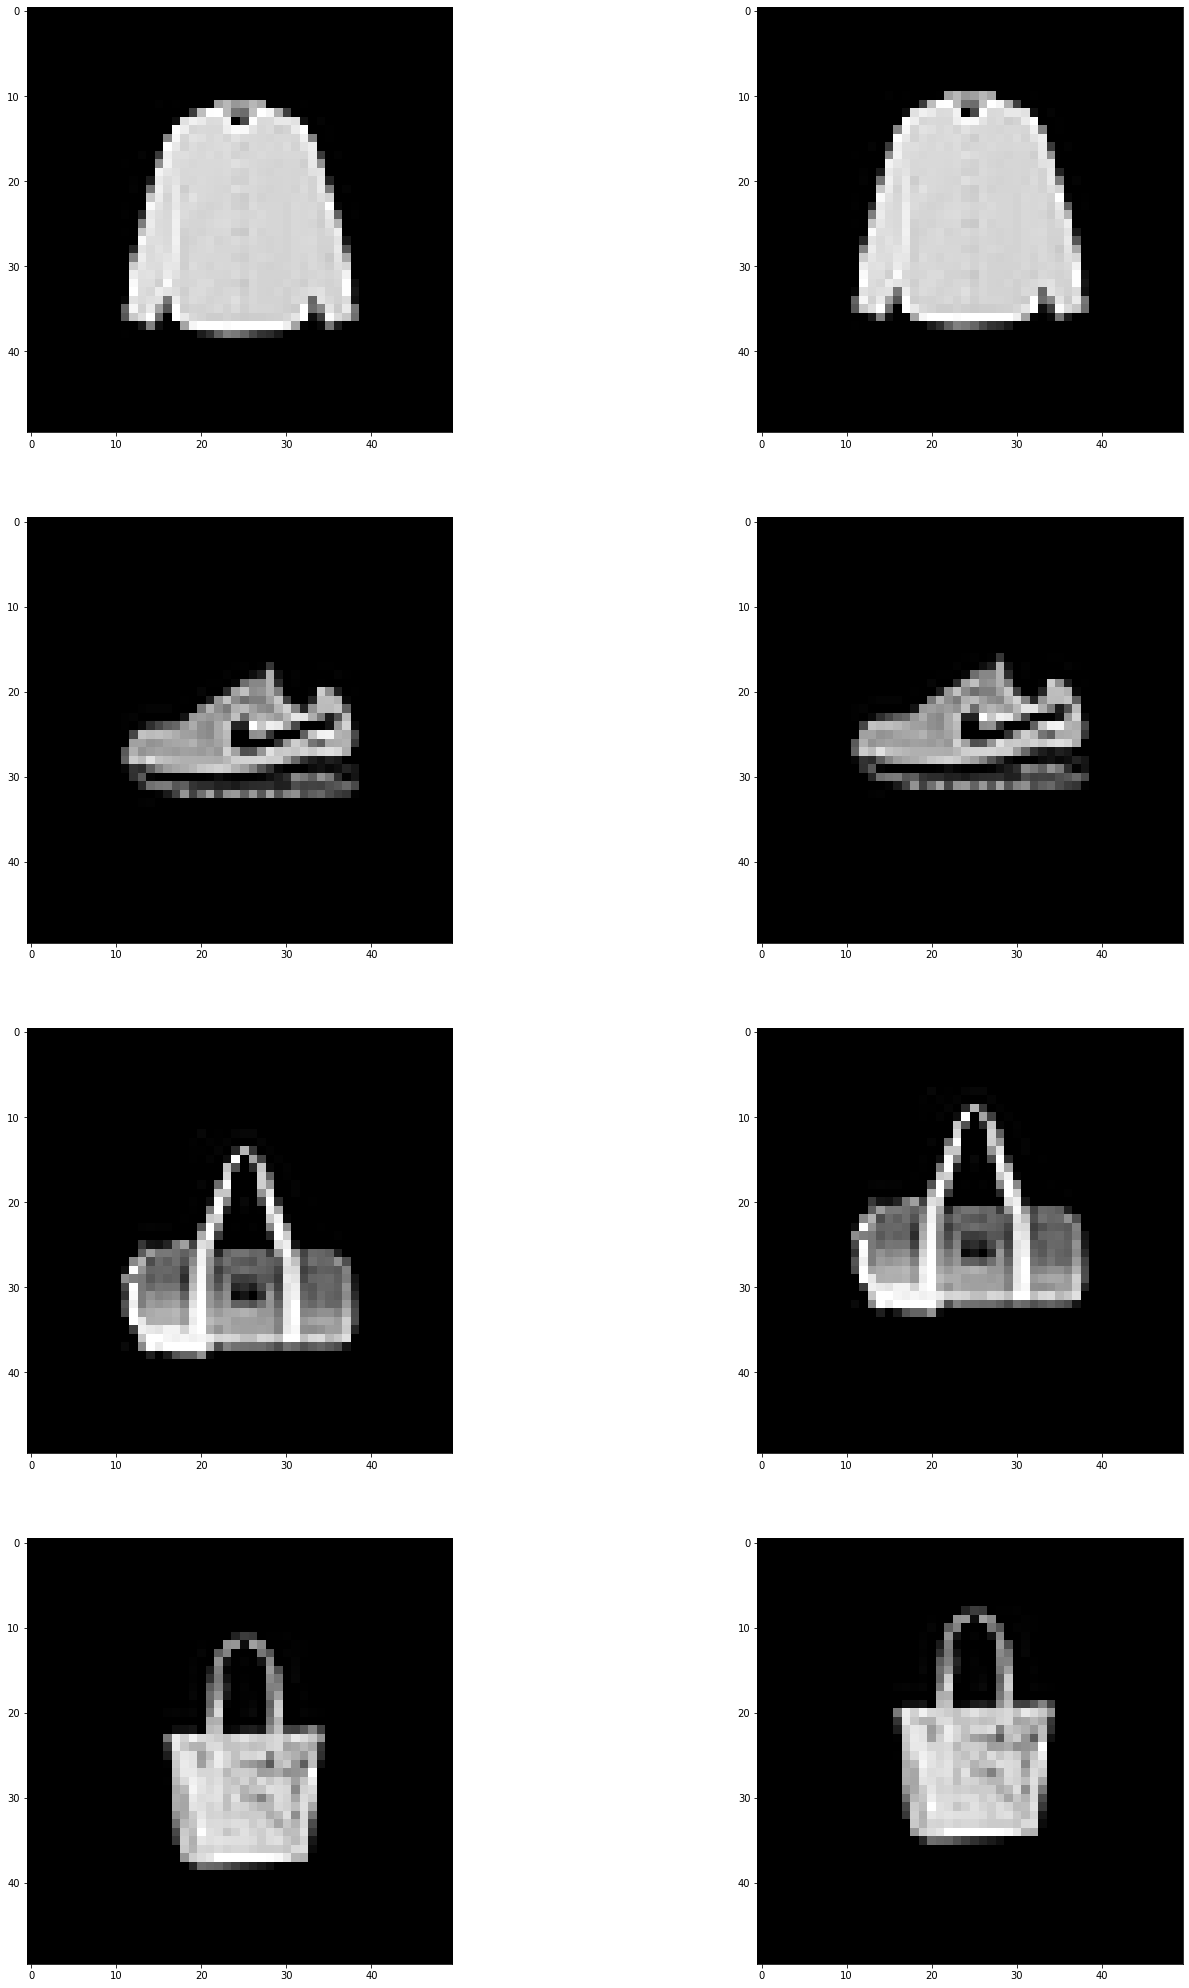

In [71]:
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu

image_center = np.array([25, 25])
offset = np.zeros((data.shape[0], 2))
test = data.copy()
for i in range(data.shape[0]):
  binary = (test[i, ...] > 20).astype(np.uint8)
  centroid = np.array(regionprops(binary)[0].centroid)
  offset[i] = np.rint(image_center - centroid)[::-1]
  im = Image.fromarray(test[i, ...].astype(np.uint8))
  data[i, ...] = np.array(affine(im, angle=0, translate=list(offset[i]), scale=1, shear=0))

fig, ax = plt.subplots(4, 2, figsize=(24, 9*4))
for i in range(4):
    n = randint(0, data.shape[0])
    print(offset[n])
    ax[i, 0].imshow(test[n,...], cmap='gray')
    ax[i, 1].imshow(data[n,...], cmap='gray')
  
del offset, test, image_center

In [72]:
from skimage.measure import label, regionprops, approximate_polygon, find_contours

def get_perimeter(image):
    img = image.copy()
    binary = (img > 20)
    perimeter = 0
    contour = sorted(find_contours(binary, 0), key=lambda x: x.shape[0])[-1]
    perimeter = approximate_polygon(contour, tolerance=0)
    return perimeter

In [73]:
def rotate_image(image, angle, image_center):
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [74]:
def translate_image(image, x, y):
    translation_matrix = np.float32([ [1,0,x], [0,1,y] ])
    img_translation = cv2.warpAffine(image, translation_matrix, image.shape[1::-1])
    return img_translation

In [75]:
from numpy.random import choice

def get_rotation_number(r1=None):
    r = 0
    if r1 is not None:
      while r == 0 or abs(r1 - r) > 50 or abs(r1 - r) == 0:
        r = choice(np.arange(start=-50, stop=51, step=10))
    else:
      while r == 0:
        r = choice(np.arange(start=-50, stop=51, step=10))
    return r

In [76]:
from numpy.random import choice

def get_rotation_number2(t=None, r1=None):
    r = 0
    if r1 is not None and t is not None:
      r = r1 - t
    else:
      while abs(r) < 10:
        r = np.random.randint(-50, 50)
    return r

In [77]:
from numpy.random import choice
'''
repeat = choice([1, 2], size=data.shape[0], p=[1, 0])
number_of_images = repeat.sum()
print('number of images = {}'.format(number_of_images))
root_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
first_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
second_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
Y = torch.zeros((number_of_images, 3), dtype=torch.int16)
second_translation = torch.zeros((number_of_images, 2), dtype=torch.int16)
count = 0
for i, j in zip(range(data.shape[0]), repeat):
    im = Image.fromarray(data[i, ...].astype(np.uint8))
    for t in range(j):
        #numbers = [randint(-10, 10), randint(-10, 10)]
        numbers = [0, 0]
        r1 = get_rotation_number()
        one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)
        #one = affine(im, angle=0, translate=numbers, scale=1, shear=0)
        #rotated = rotate_image(data[i, ...], numbers[0], (25, 25))
        #translated = translate_image(rotated, numbers[1], numbers[2])

        #numbers2 = [randint(-10, 10), randint(-10, 10)]
        numbers2 = [0, 0]
        r2 = get_rotation_number(r1)
        two = affine(im, angle=r2, translate=numbers2, scale=1, shear=0)
        #two = affine(im, angle=0, translate=numbers2, scale=1, shear=0)
        #rotated2 = rotate_image(data[i, ...], numbers2[0], (25, 25))
        #translated2 = translate_image(rotated2, numbers2[1], numbers2[2])
        
        second_images[count, ...] = two
        second_translation[count] = torch.tensor([numbers2[0], numbers2[1]])
        first_images[count, ...] = one
        root_images[count, ...] = data[i, ...]
        Y[count] = torch.tensor([r1 - r2, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
        #Y[count] = torch.tensor([0, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
        count += 1
        
del data

fig, ax = plt.subplots(4, 2, figsize=(24, 9*4))
for i in range(4):
    n = randint(0, number_of_images)
    print(Y[n])
    ax[i, 0].imshow(first_images[n,...], cmap='gray')
    ax[i, 1].imshow(second_images[n,...], cmap='gray')'''

"\nrepeat = choice([1, 2], size=data.shape[0], p=[1, 0])\nnumber_of_images = repeat.sum()\nprint('number of images = {}'.format(number_of_images))\nroot_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))\nfirst_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))\nsecond_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))\nY = torch.zeros((number_of_images, 3), dtype=torch.int16)\nsecond_translation = torch.zeros((number_of_images, 2), dtype=torch.int16)\ncount = 0\nfor i, j in zip(range(data.shape[0]), repeat):\n    im = Image.fromarray(data[i, ...].astype(np.uint8))\n    for t in range(j):\n        #numbers = [randint(-10, 10), randint(-10, 10)]\n        numbers = [0, 0]\n        r1 = get_rotation_number()\n        one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)\n        #one = affine(im, angle=0, translate=numbers, scale=1, shear=0)\n        #rotated = rotate_image(data[i, ...], numbers[0], (25, 25))\n        #translate

In [78]:
def get_translation_number(numbers):
  t1 = 0
  t2 = 0
  while abs(numbers[0] - t1) < 3:
    t1 = randint(-10, 10)
  while abs(numbers[1] - t2) < 3:
    t2 = randint(-10, 10)
  return list([t1, t2])

number of images = 70000
tensor([40, -4,  4], dtype=torch.int16)
tensor([50,  8, -8], dtype=torch.int16)
tensor([10, -4,  4], dtype=torch.int16)
tensor([10, -8,  8], dtype=torch.int16)
tensor([-50,   8,  -4], dtype=torch.int16)
tensor([-40,   8,  -4], dtype=torch.int16)
tensor([-20,  -4,  -4], dtype=torch.int16)
tensor([40,  8, -8], dtype=torch.int16)
tensor([10,  0, -8], dtype=torch.int16)
tensor([-40,   4,  -8], dtype=torch.int16)


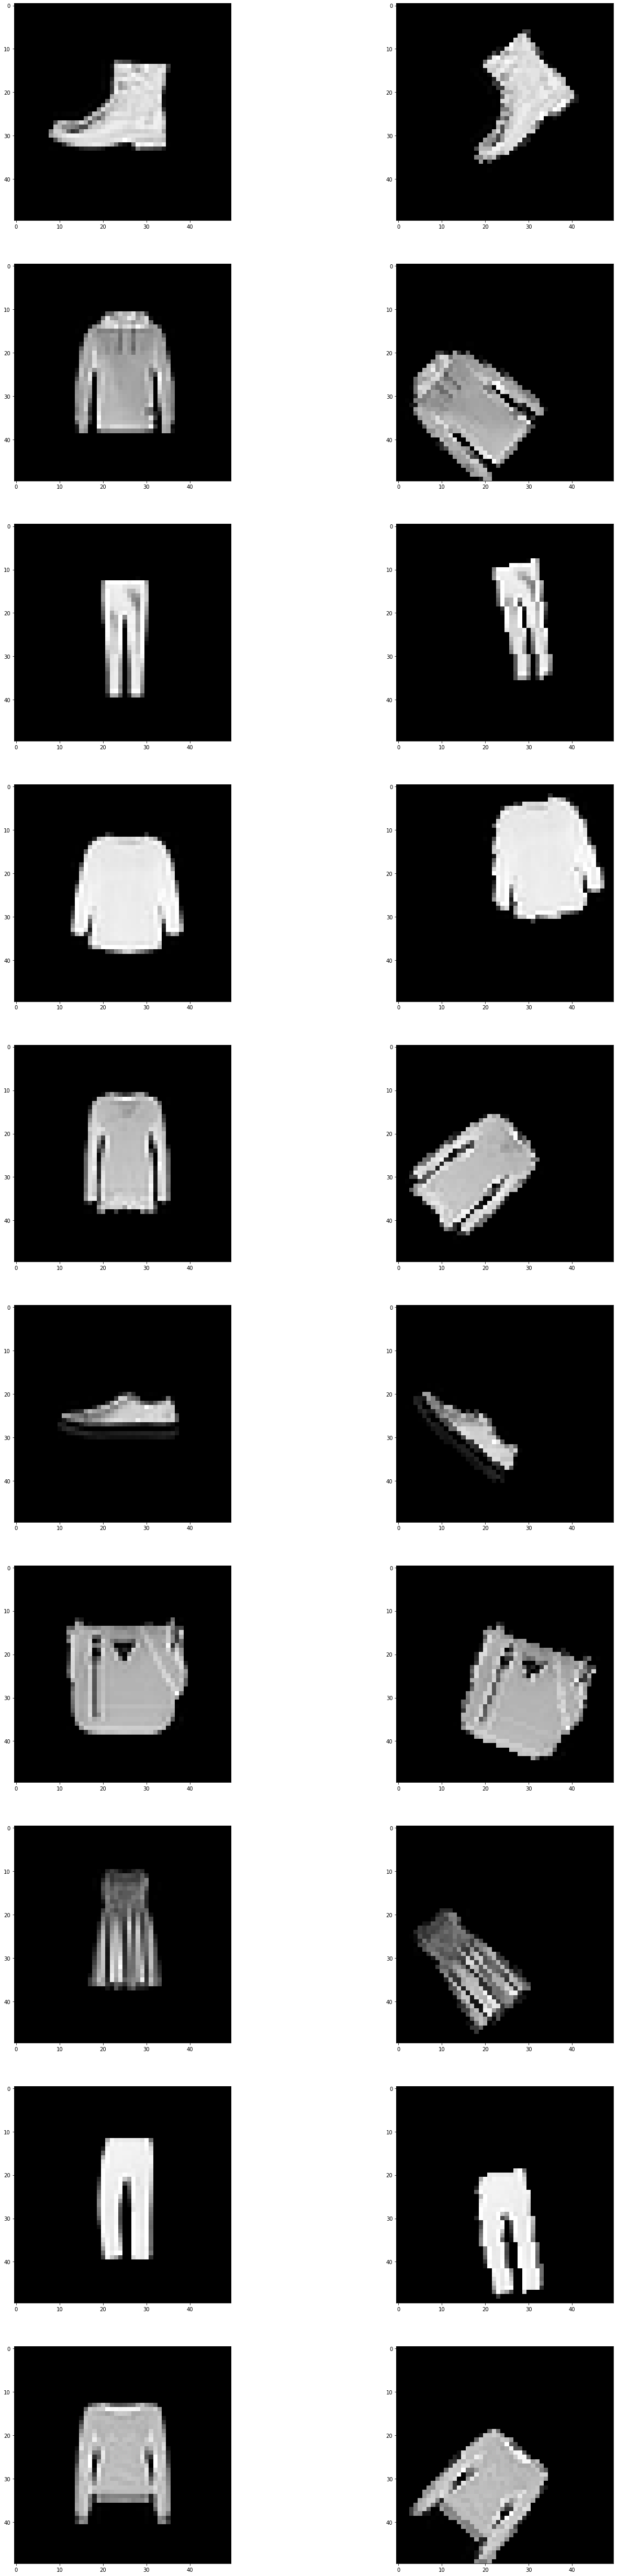

In [79]:
#repeat = choice([1, 2], size=data.shape[0], p=[0.3, 0.7])
#number_of_images = repeat.sum()
number_of_images = data.shape[0]
print('number of images = {}'.format(number_of_images))
first_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
second_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
Y = torch.zeros((number_of_images, 3), dtype=torch.int16)
count = 0
for i in range(number_of_images):
    im = Image.fromarray(data[i, ...].astype(np.uint8))
    #for t in range(-10, 11, 10):
    t = choice(np.arange(-50, 51, 10))
      #if t == 0:
      #continue
    numbers = [0, 0]
    #q = randint(-(25 - 20 + numbers[0]), 25 - 20 - numbers[0])
    #p = randint(-(25 - 20 + numbers[1]), 25 - 20 - numbers[1])
    q = choice(np.arange(-8, 9, 4))
    p = choice(np.arange(-8, 9, 4))
    #r1 = get_rotation_number2()
    r1 = 0
    one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)

    numbers2 = [numbers[0] - q, numbers[1] - p]
    #numbers2 = get_translation_number(numbers)
    r2 = r1 - t
    two = affine(im, angle=r2, translate=numbers2, scale=1, shear=0)

    second_images[count, ...] = np.array(two)
    first_images[count, ...] = np.array(one)
    Y[count] = torch.tensor([r1 - r2, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
    count += 1

fig, ax = plt.subplots(10, 2, figsize=(24, 9*10))
for i in range(10):
    n = randint(0, number_of_images)
    print(Y[n])
    ax[i, 0].imshow(first_images[n,...], cmap='gray')
    ax[i, 1].imshow(second_images[n,...], cmap='gray')

In [80]:
from math import cos, sin

class Q_value():
    def __init__(self, gamma, epsilon, R, number_of_outputs, rotation_step, translation_step):
        self.Tg = None
        self.gamma = gamma
        self.epsilon = epsilon
        self.R = R
        self.number_of_outputs = number_of_outputs
        self.rotation_step = rotation_step
        self.translation_step = translation_step

    def get_matrix_from_tensor(self, Tt):
        if self.number_of_outputs == 12:
            A = torch.tensor([[1, 0, 0, Tt[0]],
                            [0, cos(Tt[3]), -sin(Tt[3]), Tt[1]],
                            [0, sin(Tt[3]), cos(Tt[3]), Tt[2]],
                            [0, 0, 0, 1]])

            B = torch.tensor([[cos(Tt[4]), 0, sin(Tt[4]), 0],
                            [0, 0, 0, 0],
                            [-sin(Tt[4]), 0, cos(Tt[4]), 0],
                            [0, 0, 0, 1]])

            C = torch.tensor([[cos(Tt[5]), -sin(Tt[5]), 0, 0],
                            [sin(Tt[5]), cos(Tt[5]), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

            D = torch.matmul(A, B)
            return torch.matmul(D, C)
        
        elif self.number_of_outputs == 6:

            A = torch.tensor([[cos(Tt[0]), sin(Tt[0]), Tt[1]],
                            [-sin(Tt[0]), cos(Tt[0]), Tt[2]],
                            [0, 0, 1]])
            
            return A
            

    def get_optimal_action(self, Tt):
        at = torch.cat((torch.eye(self.number_of_outputs // 2), torch.eye(self.number_of_outputs // 2) * -1))
        at = at
        at_o_Tt = at + Tt.view((1, 3))
        norms = [self.get_distance(at_o_Tt[i, :]) for i in range(self.number_of_outputs)]
        return np.argmin(np.asarray(norms))
    
    def get_distance(self, x):
        if self.number_of_outputs == 4 or self.number_of_outputs == 6:
            inversed = x * -1
            composed = self.Tg + inversed
        else:
            matrice = self.get_matrix_from_tensor(x)
            inversed = torch.inverse(matrice)
            Tg_matrix = self.get_matrix_from_tensor(self.Tg)
            composed = torch.matmul(Tg_matrix, inversed)
        composed = composed.float()
        norm = torch.norm(composed).item()
        return norm
    
    def set_Tg(self, Tg):
        self.Tg = Tg

    def take_action(self, action, Tt):
        current_Tt = Tt.clone()
        if action == 0:
            current_Tt[action] += self.rotation_step
        elif action == 3:
            current_Tt[0] -= self.rotation_step
        elif action < self.number_of_outputs // 2:
          current_Tt[action] += self.translation_step
        else:
          current_Tt[action - (self.number_of_outputs // 2)] -= self.translation_step
        return current_Tt
    
    def get_reward(self, Tt, Tt_next):
        return self.get_distance(Tt) - self.get_distance(Tt_next)

    def get_q_value(self, Tt, action):
        Tt_next = self.take_action(action, Tt)
        reward = self.get_reward(Tt, Tt_next)
        if self.get_distance(Tt_next) < self.epsilon:
            return reward + self.R
        optimal_action_next = self.get_optimal_action(Tt_next)
        return reward + self.gamma * self.get_q_value(Tt_next, optimal_action_next)
    
    def get_q(self, number_of_images, Y_train, Tt):
      q_values = torch.zeros((number_of_images, 6)).to(device)
      for i in range(number_of_images):
          print('\r{}'.format(i), end='')
          self.set_Tg(Y_train[i])
          row = []
          for t in range(6):
              row.append(self.get_q_value(Tt, t))
          q_values[i, :] = torch.tensor(row).reshape((1, -1))
      return q_values

In [81]:
class Dataset_train(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Q, transform):
        'Initialization'
        self.X = X
        self.Q = Q
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Q = self.Q[index]

        return X, Q

In [82]:
class Dataset_test(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y, first_images, root_image, second_translation, transform):
        'Initialization'
        self.X = X
        self.Y = Y
        self.first_images = first_images
        #self.second_images = second_images
        self.root = root_image
        self.second_translation = second_translation
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Y = self.Y[index]
        
        one = self.first_images[index]
        #two = self.second_images[index]
        
        root_image = self.root[index]
        second_translation = self.second_translation[index]

        return X, Y, one, root_image, second_translation

In [83]:
import torchvision.transforms as transforms

X = first_images - second_images
del first_images, second_images
X = np.expand_dims(X, axis=(1))
X /= 255
#mean = X.mean()
#std = X.std()

transform = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))])
#all_indices = list(range(X.shape[0]))
#print('ok1')

#test_size_percent = 0.0000001
#test_size = test_size_percent * len(all_indices)
#train_indices, test_indices = train_test_split(all_indices, test_size=test_size_percent, random_state=42)
#del all_indices, test_indices
#X_train = torch.from_numpy(X[train_indices, ...])
#X_test = torch.from_numpy(X[test_indices, ...])
#del X
#Y_train = Y[train_indices, ...]
#Y_test = Y[test_indices, ...]
#del Y
#print('ok2')

#dataset_test = Dataset_test(X_test, Y_test, first_images[test_indices, ...], root_images[test_indices, ...], second_translation[test_indices, ...], transform)
#dataset_overfit = Dataset_test(X_train, Y_train, first_images[train_indices, ...], root_images[train_indices, ...], second_translation[train_indices, ...], transform)

#del train_indices, first_images, root_images, second_translation

#print('ok3')

#subset_indices = list(range(20))
#subset_overfit = torch.utils.data.Subset(dataset_overfit, subset_indices)
#del subset_indices

#testing_generator = torch.utils.data.DataLoader(dataset_test, 1, shuffle=True)
#overfit_generator = torch.utils.data.DataLoader(subset_overfit, 1, shuffle=True)
#del subset_overfit

In [84]:
q_value_1 = Q_value(0.9, 0.5, 10, 6, 10, 4)
Tt = torch.zeros(3)
q_values = q_value_1.get_q(X.shape[0], Y, Tt)

69999

In [86]:
dataset_train_1 = Dataset_train(X, q_values, transform)
training_generator_1 = torch.utils.data.DataLoader(dataset_train_1, 32, shuffle=True)
del X, q_values, dataset_train_1

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, d, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(w, f=3, p=0, s=1):
            return ((w - f + 2*p) // s) + 1
        
        def maxpool_size_out(w):
            return w // 2
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(w)))))))
        linear_input_size = convw * convw * 128
        
        self.head1 = nn.Linear(linear_input_size, 512)
        self.head2 = nn.Linear(512, 512)
        self.head3 = nn.Linear(512, 64)
        self.head4 = nn.Linear(64, outputs)
        
        self.linear_input_size = linear_input_size

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.maxpool1(self.conv1(x))))
        x = F.relu(self.bn2(self.maxpool2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, self.linear_input_size)
        x = F.relu(self.head1(x))
        x = F.relu(self.head2(x))
        x = F.relu(self.head3(x))
        return self.head4(x)

#for x, y in training_generator:
#    print(x.size())
 #   net = DQN(1, x.shape[2], x.shape[3], 4).float()
#    out = net(x.float())
#    print(out.max(1)[1])
#    print(torch.argmax(out, dim=1))
#    break

In [88]:
from itertools import count

policy_net_1 = DQN(1, 50, 50, 6).to(device)
correct = 0
optimizer = optim.Adam(policy_net_1.parameters())
criterion = nn.MSELoss().to(device)
running_loss = 0.0
number_of_epoch = 100

for i_episode in range(number_of_epoch):
    for index, batch in enumerate(training_generator_1):
        x = batch[0].to(device)
        q = batch[1].to(device)

        optimizer.zero_grad()
        out = policy_net_1(x.float()).to(device)

        if torch.argmax(out) == torch.argmax(q):
          correct += 1
        
        #loss = torch.norm(out - q, dim=1).sum()
        loss = criterion(out, q)

        loss.backward()
        #for param in policy_net.parameters():
         #   param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
        running_loss += loss.item()
    accuracy = correct / (index + 1)
    correct = 0
    # print statistics
    print("Epoch: {} Loss: {} Accuracy: {}".format((i_episode + 1), running_loss / (i_episode + 1), accuracy))


Epoch: 1 Loss: 43814.5425825119 Accuracy: 0.20612431444241316
Epoch: 2 Loss: 31100.561228513718 Accuracy: 0.3217550274223035
Epoch: 3 Loss: 24908.96247255802 Accuracy: 0.37751371115173676
Epoch: 4 Loss: 20887.520900130272 Accuracy: 0.4117915904936015
Epoch: 5 Loss: 18200.882190191747 Accuracy: 0.4460694698354662
Epoch: 6 Loss: 16200.773654093346 Accuracy: 0.4259597806215722
Epoch: 7 Loss: 14641.469556723323 Accuracy: 0.44149908592321757
Epoch: 8 Loss: 13395.71759609878 Accuracy: 0.46755027422303475
Epoch: 9 Loss: 12368.810996366872 Accuracy: 0.4744058500914077
Epoch: 10 Loss: 11506.12811305225 Accuracy: 0.5013711151736746
Epoch: 11 Loss: 10771.534219072624 Accuracy: 0.49725776965265084
Epoch: 12 Loss: 10122.849478825927 Accuracy: 0.5036563071297989
Epoch: 13 Loss: 9563.799835159229 Accuracy: 0.5118829981718465
Epoch: 14 Loss: 9075.182267359325 Accuracy: 0.5342778793418648
Epoch: 15 Loss: 8637.226305784781 Accuracy: 0.5365630712979891
Epoch: 16 Loss: 8237.074778260663 Accuracy: 0.522394

number of images = 70000
tensor([ 0, -4, -4], dtype=torch.int16)
tensor([ 0,  0, -3], dtype=torch.int16)
tensor([ 0, -2,  1], dtype=torch.int16)
tensor([0, 4, 2], dtype=torch.int16)
tensor([ 0,  4, -4], dtype=torch.int16)
tensor([ 0, -1, -3], dtype=torch.int16)
tensor([ 0,  2, -2], dtype=torch.int16)
tensor([ 0,  4, -4], dtype=torch.int16)
tensor([ 0, -2, -3], dtype=torch.int16)
tensor([0, 0, 3], dtype=torch.int16)


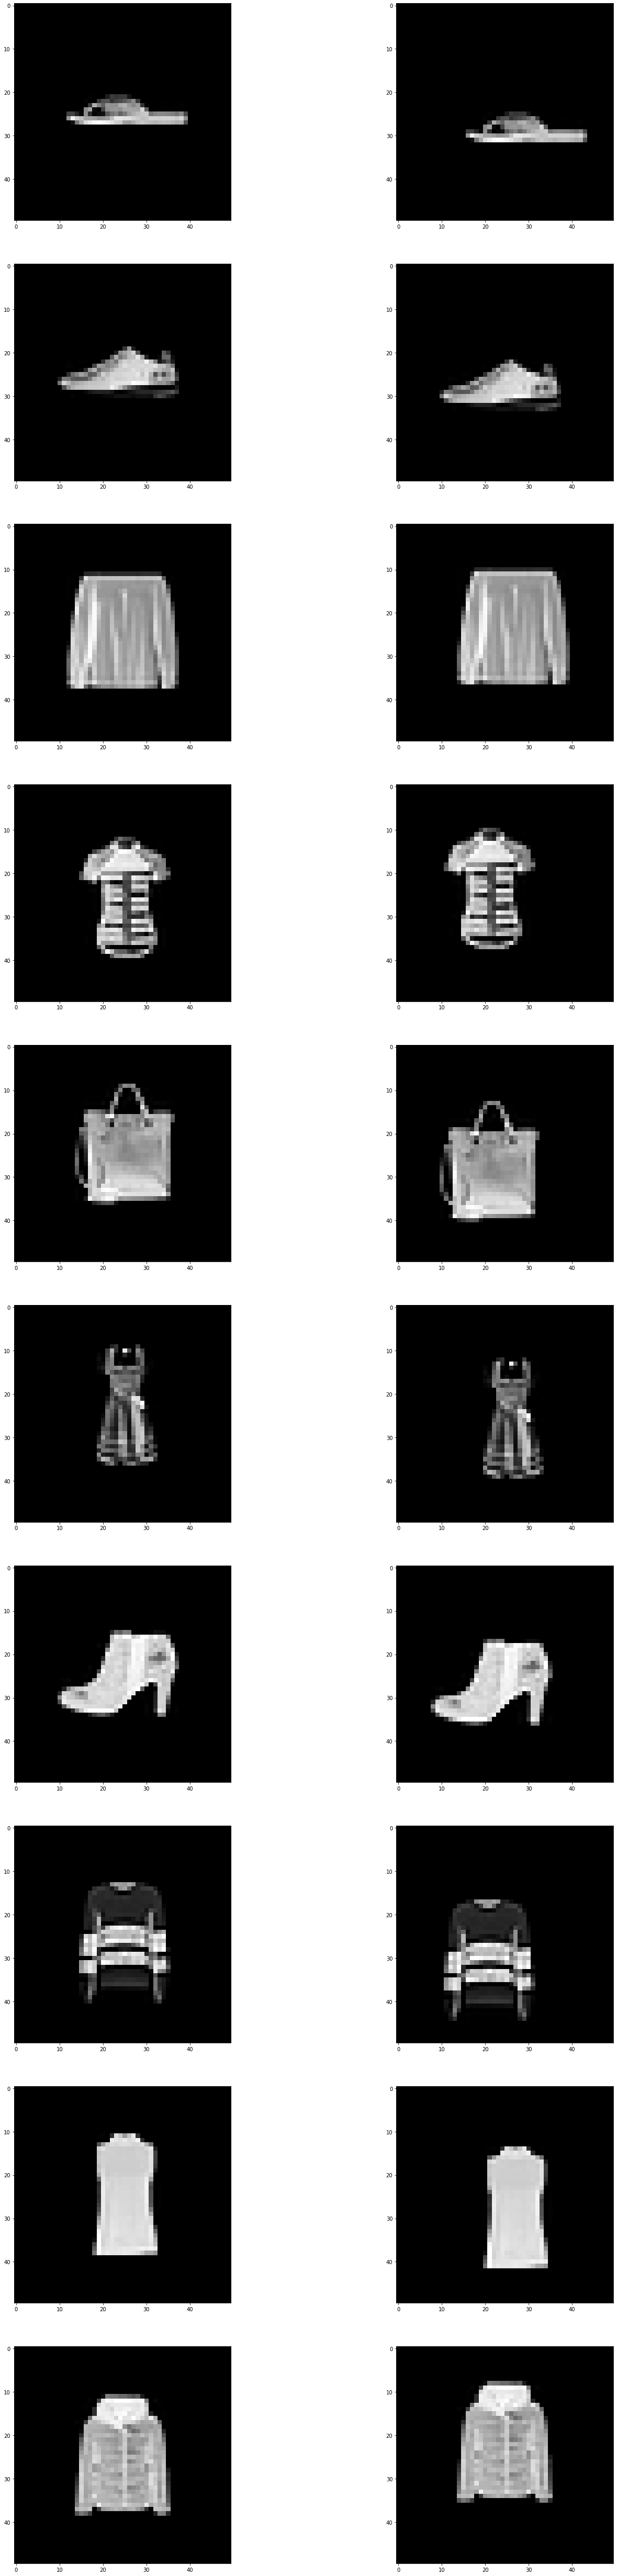

In [89]:
#repeat = choice([1, 2], size=data.shape[0], p=[0.3, 0.7])
#number_of_images = repeat.sum()
number_of_images = data.shape[0]
print('number of images = {}'.format(number_of_images))
first_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
second_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
Y = torch.zeros((number_of_images, 3), dtype=torch.int16)
count = 0
for i in range(number_of_images):
    im = Image.fromarray(data[i, ...].astype(np.uint8))
    #for t in range(-10, 11, 10):
    #t = choice(np.arange(-5, 6, 5))
    t = 0
      #if t == 0:
      #continue
    numbers = [0, 0]
    #q = randint(-(25 - 20 + numbers[0]), 25 - 20 - numbers[0])
    #p = randint(-(25 - 20 + numbers[1]), 25 - 20 - numbers[1])
    q = choice(np.arange(-4, 5, 1))
    p = choice(np.arange(-4, 5, 1))
    #r1 = get_rotation_number2()
    r1 = 0
    one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)

    numbers2 = [numbers[0] - q, numbers[1] - p]
    #numbers2 = get_translation_number(numbers)
    r2 = r1 - t
    two = affine(im, angle=r2, translate=numbers2, scale=1, shear=0)

    second_images[count, ...] = np.array(two)
    first_images[count, ...] = np.array(one)
    Y[count] = torch.tensor([r1 - r2, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
    count += 1

fig, ax = plt.subplots(10, 2, figsize=(24, 9*10))
for i in range(10):
    n = randint(0, number_of_images)
    print(Y[n])
    ax[i, 0].imshow(first_images[n,...], cmap='gray')
    ax[i, 1].imshow(second_images[n,...], cmap='gray')

In [90]:
import torchvision.transforms as transforms

X = first_images - second_images
del first_images, second_images
X = np.expand_dims(X, axis=(1))
X /= 255

transform = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))])

In [91]:
q_value_2 = Q_value(0.9, 0.5, 10, 6, 0, 1)
Tt = torch.zeros(3)
q_values = q_value_2.get_q(X.shape[0], Y, Tt)
del Y

69999

In [92]:
dataset_train_2 = Dataset_train(X, q_values, transform)
training_generator_2 = torch.utils.data.DataLoader(dataset_train_2, 32, shuffle=True)
del X, q_values, dataset_train_2

In [93]:
from itertools import count

policy_net_2 = DQN(1, 50, 50, 6).to(device)
correct = 0
optimizer = optim.Adam(policy_net_2.parameters())
criterion = nn.MSELoss().to(device)
running_loss = 0.0
number_of_epoch = 100

for i_episode in range(number_of_epoch):
    for index, batch in enumerate(training_generator_2):
        x = batch[0].to(device)
        q = batch[1].to(device)

        optimizer.zero_grad()
        out = policy_net_2(x.float()).to(device)

        if torch.argmax(out) == torch.argmax(q):
          correct += 1
        
        #loss = torch.norm(out - q, dim=1).sum()
        loss = criterion(out, q)

        loss.backward()
        #for param in policy_net.parameters():
         #   param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
        running_loss += loss.item()
    accuracy = correct / (index + 1)
    correct = 0
    # print statistics
    print("Epoch: {} Loss: {} Accuracy: {}".format((i_episode + 1), running_loss / (i_episode + 1), accuracy))

Epoch: 1 Loss: 755.8336001839489 Accuracy: 0.2655393053016453
Epoch: 2 Loss: 451.1540287430398 Accuracy: 0.36745886654478976
Epoch: 3 Loss: 336.27694449573755 Accuracy: 0.4040219378427788
Epoch: 4 Loss: 272.0860168831423 Accuracy: 0.4063071297989031
Epoch: 5 Loss: 231.8992138462141 Accuracy: 0.43784277879341865
Epoch: 6 Loss: 202.660746189688 Accuracy: 0.44744058500914075
Epoch: 7 Loss: 181.2520711002206 Accuracy: 0.4922303473491773
Epoch: 8 Loss: 164.16192396869883 Accuracy: 0.4844606946983547
Epoch: 9 Loss: 150.59069406411922 Accuracy: 0.4716636197440585
Epoch: 10 Loss: 139.2021448245505 Accuracy: 0.49725776965265084
Epoch: 11 Loss: 129.52125841455364 Accuracy: 0.5146252285191956
Epoch: 12 Loss: 121.33347780245822 Accuracy: 0.5150822669104205
Epoch: 13 Loss: 114.1271413762588 Accuracy: 0.5228519195612431
Epoch: 14 Loss: 107.79174686589145 Accuracy: 0.5361060329067642
Epoch: 15 Loss: 102.25397396447758 Accuracy: 0.506398537477148
Epoch: 16 Loss: 97.36067860286857 Accuracy: 0.542961608

number of images = 20
20
tensor([20,  7,  2], dtype=torch.int16)
tensor([-40,   4,  -8], dtype=torch.int16)
tensor([50, -4, -6], dtype=torch.int16)
tensor([-30,  -1,   3], dtype=torch.int16)
tensor([40, -3, -3], dtype=torch.int16)
tensor([50,  3, -1], dtype=torch.int16)
tensor([50, -4, -6], dtype=torch.int16)
tensor([ 0, -3,  4], dtype=torch.int16)
tensor([-30,  -1,   3], dtype=torch.int16)
tensor([50,  3, -1], dtype=torch.int16)


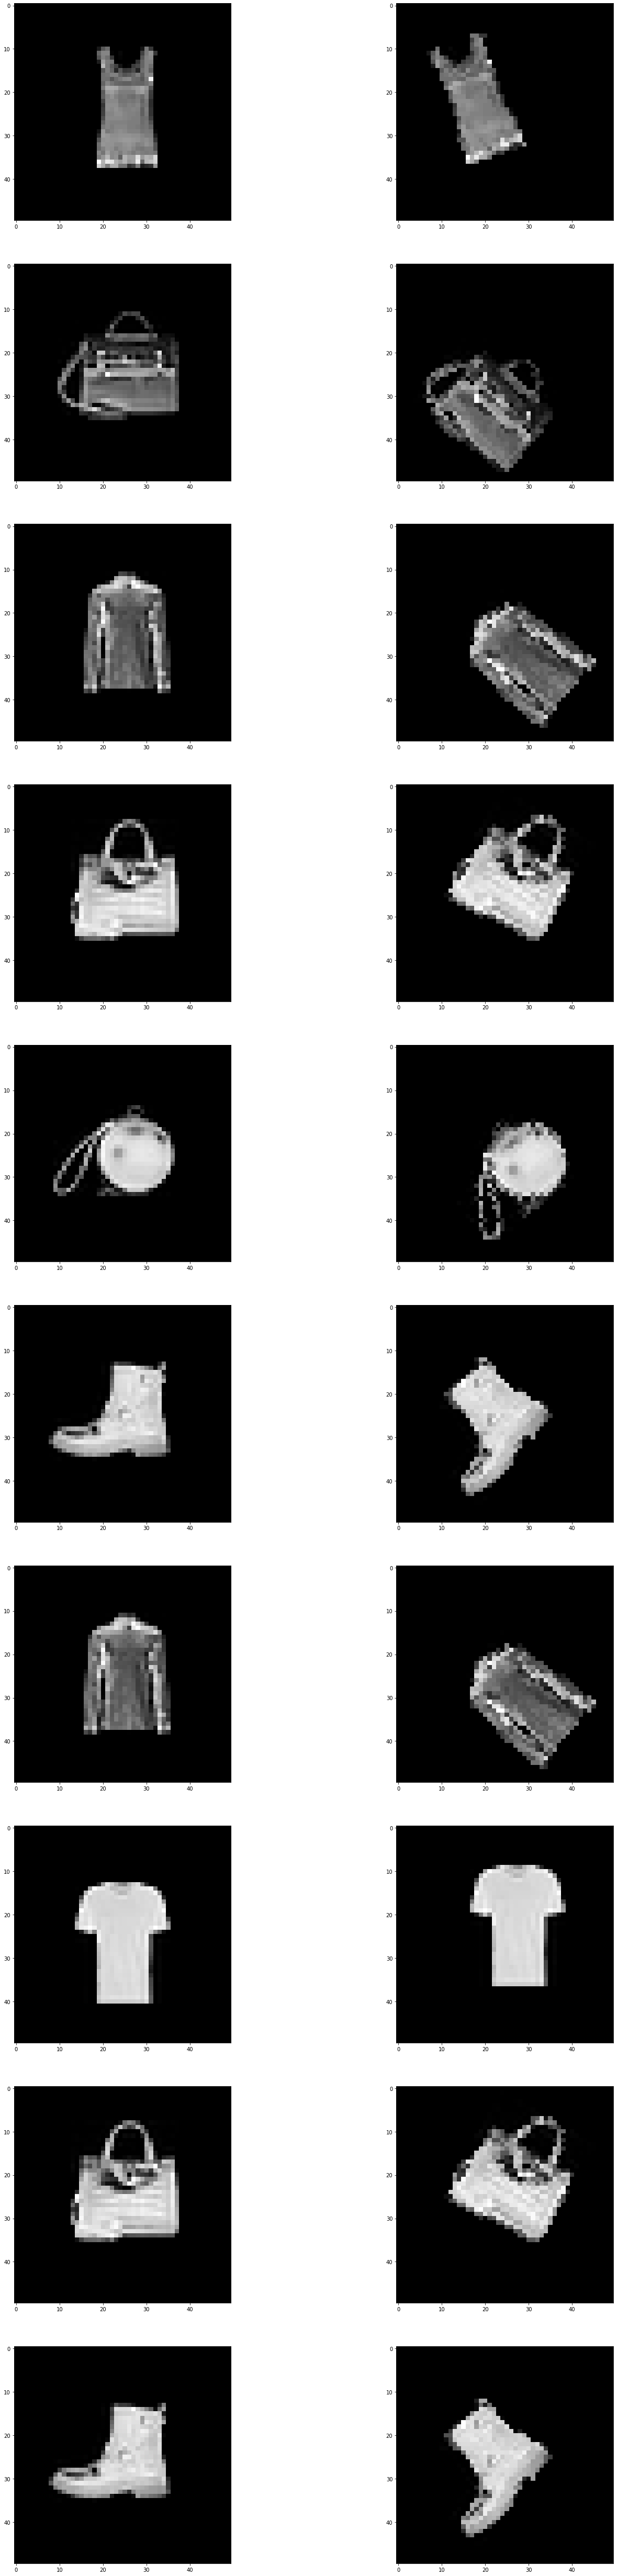

In [94]:
#repeat = choice([1, 2], size=data.shape[0], p=[0.3, 0.7])
#number_of_images = repeat.sum()
number_of_images = 20
images_index = np.random.randint(0, data.shape[0], number_of_images)
print('number of images = {}'.format(number_of_images))
root_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
first_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
second_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
Y = torch.zeros((number_of_images, 3), dtype=torch.int16)
second_translation = torch.zeros((number_of_images, 2), dtype=torch.int16)
count = 0
for i in images_index:
    im = Image.fromarray(data[i, ...].astype(np.uint8))
    #for t in range(-10, 11, 10):
    t = choice(np.arange(-50, 51, 10))
      #if t == 0:
      #continue
    numbers = [0, 0]
    #q = randint(-(25 - 20 + numbers[0]), 25 - 20 - numbers[0])
    #p = randint(-(25 - 20 + numbers[1]), 25 - 20 - numbers[1])
    q = choice(np.arange(-8, 9, 1))
    p = choice(np.arange(-8, 9, 1))
    #r1 = get_rotation_number2()
    r1 = 0
    one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)

    numbers2 = [numbers[0] - q, numbers[1] - p]
    #numbers2 = get_translation_number(numbers)
    r2 = r1 - t
    two = affine(im, angle=r2, translate=numbers2, scale=1, shear=0)

    second_images[count, ...] = np.array(two)
    second_translation[count] = torch.tensor([numbers2[0], numbers2[1]])
    first_images[count, ...] = np.array(one)
    numbers_root = [x * -1 for x in numbers2]
    root_images[count, ...] = np.array(affine(two, angle=0, translate=numbers_root, scale=1, shear=0))
    Y[count] = torch.tensor([r1 - r2, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
    count += 1
        
del data
print(count)

fig, ax = plt.subplots(10, 2, figsize=(24, 9*10))
for i in range(10):
    n = randint(0, number_of_images)
    print(Y[n])
    ax[i, 0].imshow(first_images[n,...], cmap='gray')
    ax[i, 1].imshow(second_images[n,...], cmap='gray')

In [95]:
import torchvision.transforms as transforms

X = first_images - second_images
del second_images
X = np.expand_dims(X, axis=(1))
X /= 255

transform = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))])

dataset_test = Dataset_test(X, Y, first_images, root_images, second_translation, transform)
del X, Y, first_images, root_images, second_translation
testing_generator = torch.utils.data.DataLoader(dataset_test, 1, shuffle=True)

In [101]:
from torchvision.transforms.functional import normalize, to_pil_image, to_tensor

policy_nets = [policy_net_1, policy_net_2]
q_values = [q_value_1, q_value_2]
correct = 0
total = 20
number_of_steps = 200
list_of_examples = []
perimeters = []
with torch.no_grad():
    for data in testing_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2]
        root_image = to_pil_image(data[3].int())
        second_translation = data[4]
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        perimeters.append(get_perimeter(first_image[0, ...].numpy()))
        j = 0
        for index, (policy_net, q_value) in enumerate(zip(policy_nets, q_values)):
          print(index)
          while j < number_of_steps - 1:
              out = policy_net(x.float())
              #print(torch.argmax(q_value.get_q(1, y, Tt[j]), dim=1).item())
              #print(torch.argmax(out, dim=1).item())
              #print('##########################################################################')
              action = torch.argmax(out, dim=1)
              Tt[j + 1, :] = q_value.take_action(action, Tt[j, :])
              print(Tt[j + 1])
              translation = (Tt[j + 1, 1].item() + second_translation[0, 0].item(), Tt[j + 1, 2].item() + second_translation[0, 1].item())
              current_image = to_tensor(affine(root_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
              list_of_frames.append(current_image.numpy().reshape((50, 50)))
              diff = first_image - current_image
              diff /= 255
              x = diff.unsqueeze(0).to(device)
              if torch.unique(Tt[:j + 2], dim=0).size(0) == torch.unique(Tt[:j + 1], dim=0).size(0):
                  if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                      correct += 1
                  j += 1
                  break
              j += 1
        stack_of_frames = np.stack(list_of_frames)
        #stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        mask = Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)
        Tt = Tt[~mask]
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

***************************
tensor([[40, -3, -3]], dtype=torch.int16)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
0
tensor([-10,   0,   0], dtype=torch.int16)
tensor([-20,   0,   0], dtype=torch.int16)
tensor([-30,   0,   0], dtype=torch.int16)
tensor([-40,   0,   0], dtype=torch.int16)
tensor([-30,   0,   0], dtype=torch.int16)
1
tensor([-30,  -1,   0], dtype=torch.int16)
tensor([-30,  -1,  -1], dtype=torch.int16)
tensor([-30,  -2,  -1], dtype=torch.int16)
tensor([-30,  -2,  -2], dtype=torch.int16)
tensor([-30,  -2,  -1], dtype=torch.int16)
tensor([[-10,   0,   0],
        [-20,   0,   0],
        [-30,   0,   0],
        [-40,   0,   0],
        [-30,   0,   0],
        [-30,  -1,   0],
        [-30,  -1,  -1],
        [-30,  -2,  -1],
        [-30,  -2,  -2],
        [-30,  -2,  -1]], dtype=torch.int16)
***************************
tensor([[-10,   5,  -8]], dtype=torch.int16)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
0
tensor([-10,   0,   0], dtype=torch.int16)
tensor([-20,   0,   0], dtype=torch.int16)
tensor(

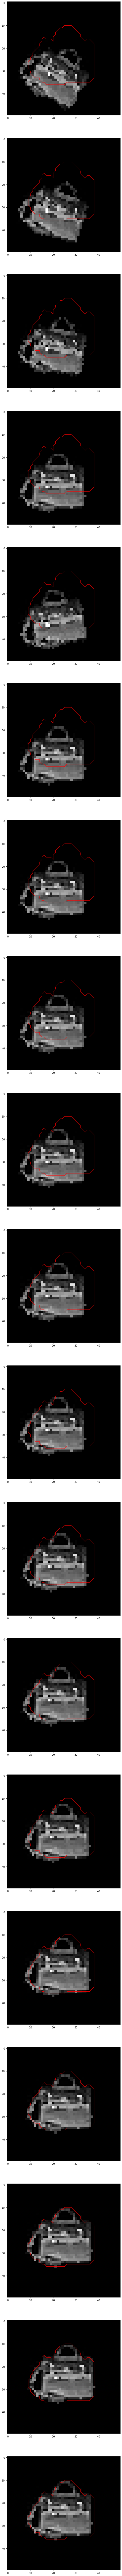

In [102]:
index = np.argmax([x.shape[0] for x in list_of_examples])
frames = list_of_examples[index]
perimeter = perimeters[index]
fig, ax = plt.subplots(frames.shape[0], 1, figsize=(16, 10*frames.shape[0]))
for i in range(frames.shape[0]):
    ax[i].plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
    ax[i].imshow(frames[i], cmap='gray')

In [98]:
def display(img, perimeters, slice_number):
    plt.figure(figsize=(16, 9))
    plt.plot(perimeters[:, 1], perimeters[:, 0], '-r', linewidth=1)
    plt.imshow(img[slice_number, ...], cmap='gray')

In [103]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("/content/output.pdf")
library = np.concatenate(list_of_examples)
perimeters_thresh = [x.shape[0] for x in list_of_examples]
cum_thresh = np.cumsum(perimeters_thresh)
j = 0
i = 0
while i < library.shape[0]:
  if i >= cum_thresh[j]:
    j += 1
  perimeter = perimeters[j]
  fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  ax.plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
  ax.imshow(library[i], cmap='gray')
  i += 1
  pdf.savefig(fig, bbox_inches='tight')
  plt.close(fig)
pdf.close()

#library = np.stack(list_of_examples)
#for i in range(10):
#    interact(display, img=fixed(library[i, ...]), perimeters=fixed(perimeters[i]), slice_number=widgets.IntSlider(min=0, max=library[i, ...].shape[0] - 1, step=1, value=0))

In [100]:
from torchvision.transforms.functional import normalize, to_pil_image, to_tensor

correct = 0
total = 30
number_of_steps = 200
list_of_examples = []
perimeters = []
with torch.no_grad():
    for data in overfit_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2]
        #second_image = data[3].numpy()
        #second_image = to_pil_image(data[3].int())
        root_image = to_pil_image(data[3].int())
        second_translation = data[4]
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        j = 0
        perimeters.append(get_perimeter(first_image[0, ...].numpy()))
        while j < number_of_steps - 1:
            out = policy_net(x.float())
            print(torch.argmax(q_value.get_q(1, y, Tt[j]), dim=1).item())
            print(torch.argmax(out, dim=1).item())
            print('##########################################################################')
            action = torch.argmax(out, dim=1)
            Tt[j + 1, :] = q_value.take_action(action, Tt[j, :])
            #if j > 5 and torch.all(Tt[j + 1, :].eq(Tt[j - 1, :])):
            if torch.unique(Tt[:j + 2], dim=0).size(0) == torch.unique(Tt[:j + 1], dim=0).size(0):
                if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                    correct += 1
                break
            translation = (Tt[j + 1, 1].item() + second_translation[0, 0].item(), Tt[j + 1, 2].item() + second_translation[0, 1].item())
            #translated = translate_image(second_image[0, ...], Tt_new[1].item(), Tt_new[2].item())
            #current_image = rotate_image(translated, Tt_new[0].item(), (second_position[0, 0] + Tt_new[1].item(), second_position[0, 1] + Tt_new[2].item()))
            current_image = to_tensor(affine(root_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
            list_of_frames.append(current_image.numpy().reshape((50, 50)))
            diff = first_image - current_image
            diff /= 255
            x = diff.unsqueeze(0).to(device)
            j += 1
        stack_of_frames = np.stack(list_of_frames)
        #stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        mask = Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)
        Tt = Tt[~mask]
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

NameError: ignored

In [ ]:
print(Y_test)

In [ ]:
from torchvision.transforms.functional import normalize

correct = 0
total = test_size
number_of_steps = 200
list_of_examples = []
perimeters = []
with torch.no_grad():
    for data in testing_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2]
        #second_image = data[3].numpy()
        #second_image = to_pil_image(data[3].int())
        root_image = to_pil_image(data[3].int())
        second_translation = data[4]
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        j = 0
        perimeters.append(get_perimeter(first_image[0, ...].numpy()))
        while j < number_of_steps - 1:
            out = policy_net(x.float())
            action = torch.argmax(out, dim=1)
            Tt[j + 1, :] = q_value.take_action(action, Tt[j, :])
            if j > 0 and torch.all(Tt[j + 1, :].eq(Tt[j - 1, :])) :
                if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                    correct += 1
                break
            translation = (Tt[j + 1, 1].item() + second_translation[0, 0].item(), Tt[j + 1, 2].item() + second_translation[0, 1].item())
            #translated = translate_image(second_image[0, ...], Tt_new[1].item(), Tt_new[2].item())
            #current_image = rotate_image(translated, Tt_new[0].item(), (second_position[0, 0] + Tt_new[1].item(), second_position[0, 1] + Tt_new[2].item()))
            current_image = to_tensor(affine(root_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
            list_of_frames.append(current_image.numpy().reshape((50, 50)))
            diff = first_image - current_image
            diff /= 255
            x = diff.unsqueeze(0).to(device)
            j += 1
        stack_of_frames = np.stack(list_of_frames)
        stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        Tt = Tt[~Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)]
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

In [ ]:
library = np.stack(list_of_examples)
for i in range(test_size):
    interact(display, img=fixed(library[i, ...]), perimeters=fixed(perimeters[i]), slice_number=widgets.IntSlider(min=0, max=library[i, ...].shape[0] - 1, step=1, value=0))